In [10]:
# read data

from mnist import MNIST
import numpy as np
mndata = MNIST('C:\\Users\\Divya\\Google Drive\\Acads\\Courses-Winter2018\\CSE253-NeuralNetworks\\neuralnets253\\HW1')
mndata.gz = True
images, labels = mndata.load_training() #Images is a list of 60000 images of 784 dimensions, Labels is a list of 60000 ints
imagesTest, labelsTest = mndata.load_testing()

images = np.array(images)
labels = np.array(labels)
imagesTest = np.array(imagesTest)
labelsTest = np.array(labelsTest)
images = np.insert(images, 0, 1, axis=1)
imagesTest = np.insert(imagesTest, 0, 1, axis=1)

In [11]:
images_train_all = images[:20000]
images_test_all = imagesTest[-2000:]
labels_train_all = labels[:20000]
labels_test_all = labelsTest[-2000:]

images_train = []
images_test = []
labels_train = []
labels_test = []

# Extract the training examples for 2 and 3
for i in range(len(labels_train_all)):
    if (labels_train_all[i] == 2):
        images_train.append(images_train_all[i])
        labels_train.append(1)
    if (labels_train_all[i] == 3):
        images_train.append(images_train_all[i])
        labels_train.append(0)
        
for i in range(len(labels_test_all)):
    if (labels_test_all[i] == 2):
        images_test.append(images_test_all[i])
        labels_test.append(1)
    if (labels_test_all[i] == 3):
        images_test.append(images_test_all[i])
        labels_test.append(0)

images_train = np.array(images_train)
labels_train = np.array(labels_train)
images_test = np.array(images_test)
labels_test = np.array(labels_test)

# Normalization
images_train = images_train*(1/255)
images_test = images_test*(1/255)

numFeatures = len(images[0, :])

# Divide between validation and training
from sklearn.model_selection import train_test_split
images_train, images_validation, labels_train, labels_validation = train_test_split(images_train, labels_train, test_size=0.10)

In [17]:
# Helper functions

import math
from sklearn.metrics import accuracy_score

numIterations = 10000

# Predict label based on the pr
def predictLabel(a):
    if (a >= 0.5):
        return 1
    return 0

def predictionAccuracy(x, weights, t):
    predictedOutput = predictY(x, weights)
    for i in range(len(predictedOutput)):
        predictedOutput[i] = predictLabel(predictedOutput[i])
    return accuracy_score(t, predictedOutput)

def errorFunction(weights, x, t, reg, l2):
    numExamples = len(x)
    predictedOutput = predictY(x, weights)
    error = 0
    examplesCounted = 0
    for i in range(numExamples):
        if (predictedOutput[i] < 1 and predictedOutput[i] > 0):
            error += t[i]*math.log(predictedOutput[i])+(1-t[i])*math.log(1-predictedOutput[i])
            examplesCounted += 1
    error = -1*(error/examplesCounted)
    if(l2):
        error += reg*np.sum(np.square(weights))
    else:
        error += reg*np.sum(np.abs(weights))
    return error

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def predictY(x, weights):
    predictedOutput = np.dot(x, weights)
    for i in range(len(predictedOutput)):
        predictedOutput[i] = sigmoid(predictedOutput[i])
    return predictedOutput

def updateWeights(weights, x, t, learningRate, regularization, l2):
    predicted = predictY(x, weights)
    diffPredictedActual = predicted-t
#     print(x.shape)
#     print(diffPredictedActual.shape)
    differentiation = (diffPredictedActual.T).dot(x)
    differentiation = differentiation*(1/len(x))
#     print(differentiation.shape)
    if (l2 == True):
        differentiation += 2*regularization*weights
    else:
        diffRegularizer = np.zeros(len(weights))
        for i in range(len(weights)):
            if weights[i] == 0:
                diffRegularizer[i] = 0
            elif weights[i] > 0:
                diffRegularizer[i] = 1
            else:
                diffRegularizer[i] = -1
        differentiation += regularization*(diffRegularizer)
    differentiation = differentiation
    newWeights = (weights-learningRate*differentiation)
    return newWeights

In [18]:
import matplotlib.pyplot as plt

def gradientDescent(x, t, testLam, regularization, annealingParameter, l2):
    images_train = x[0]
    images_validation = x[1]
    images_test = x[2]
    labels_train = t[0]
    labels_validation = t[1]
    labels_test = t[2]
    
#     weights = np.random.normal(0, 1, numFeatures)
    weights = np.zeros(numFeatures)
    weightsMinError = np.zeros(numFeatures)
    minErrorFunction = float('inf')
    prevValidationError = 0.0
    cnt = 0
    stoppingIteration = 1
    iterationMinWeight = 0
    arrTrainingError = []
    arrValidationError = []
    arrTestError = []
    arrTrainClassificationAccuracy = []
    arrValidationClassificationAccuracy = []
    arrTestClassificationAccuracy = []

    for i in range(1000):
        currLearningRate = testLam/(1+(i/annealingParameter))
        weights = updateWeights(weights, images_train, labels_train, currLearningRate, regularization, l2)
        trainAccuracy = predictionAccuracy(images_train, weights, labels_train)
        validationAccuracy = predictionAccuracy(images_validation, weights, labels_validation)
        testAccuracy = predictionAccuracy(images_test, weights, labels_test)
        currValidationError = errorFunction(weights, images_validation, labels_validation, regularization, l2)
        currTestError = errorFunction(weights, images_test, labels_test, regularization, l2)
        currTrainError = errorFunction(weights, images_train, labels_train, regularization, l2)
        arrTrainingError.append(currTrainError)
        arrValidationError.append(currValidationError)
        arrTestError.append(currTestError)
        arrTrainClassificationAccuracy.append(trainAccuracy)
        arrValidationClassificationAccuracy.append(validationAccuracy)
        arrTestClassificationAccuracy.append(testAccuracy)
#         if (i%100 == 0):
#             print("Iteration = ", i)
#             print("Current validation error = ", currValidationError)
#             print("Current classification accuracy = ", validationAccuracy)
        if (currValidationError < minErrorFunction):
            weightsMinError = weights
            minErrorFunction = currValidationError
            iterationMinWeight = i
        if (currValidationError > prevValidationError):
            cnt += 1
            if (cnt >= 3 and i > 50):
                stoppingIteration = i
                break
        else:
            cnt = 0
        prevValidationError = currValidationError

    print("Iteration of min weights = ", iterationMinWeight)
    print("Stopping iteration = ", stoppingIteration)
    
    testAccuracyFinal = predictionAccuracy(images_test, weightsMinError, labels_test)
    validationAccuracyFinal = predictionAccuracy(images_validation, weightsMinError, labels_validation)
    trainAccuracyFinal = predictionAccuracy(images_train, weightsMinError, labels_train)
    print("Final train classification accuracy = ", trainAccuracyFinal)
    print("Final validation classification accuracy = ", validationAccuracyFinal)
    print("Final test classification accuracy = ", testAccuracyFinal)

    plt.figure(1)
    plt.subplot(211)
    plt.plot(arrTrainingError, label='Train', color='blue')
    plt.plot(arrValidationError, label='Validation', color='green')
    plt.plot(arrTestError, label='Test', color='red')
    plt.ylabel('Error')
    plt.xlabel('Iterations')

    plt.subplot(212)
    plt.plot(arrTrainClassificationAccuracy, label='Train', color='blue')
    plt.plot(arrValidationClassificationAccuracy, label='Validation', color='green')
    plt.plot(arrTestClassificationAccuracy, label='Test', color='red')
    plt.ylabel('Accuracy')
    plt.xlabel('Iterations')
    plt.show()
    
    return weightsMinError
    
#     plt.imshow(weights,interpolation='none', cmap='inferno')
#     plt.title("2 vs 3 weights after training")
#     plt.show()
    
    print("********************************************************************************")

Learning rate =  0.1
Iteration of min weights =  999
Stopping iteration =  1
Final train classification accuracy =  0.971420643729
Final validation classification accuracy =  0.965087281796
Final test classification accuracy =  0.98024691358


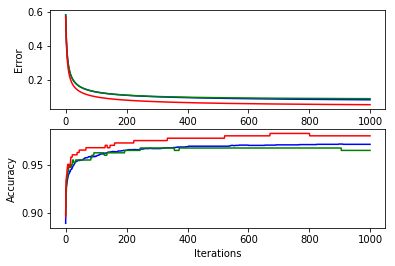

In [14]:
# No regularization

x = [images_train, images_validation, images_test]
t = [labels_train, labels_validation, labels_test]
generatedWeights = []

for learning_rate in [0.1]:
    print("Learning rate = ", learning_rate)
    weightsCurr = gradientDescent(x, t, learning_rate, 0.0, 1000, True)
    generatedWeights.append(weightsCurr)

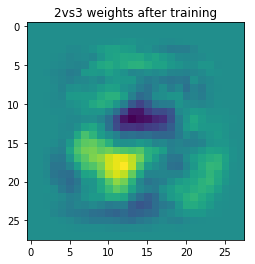

In [16]:
# 2 vs 3 with learning rate 0.1

theta23Image = np.resize(np.array(generatedWeights[0][1:]),(28,28))
plt.imshow(theta23Image,interpolation='none')
plt.title("2vs3 weights after training")
plt.show()

Iteration of min weights =  1218
Stopping iteration =  1221
Final train classification accuracy =  0.9750277469478358
Final validation classification accuracy =  0.972568578553616
Final test classification accuracy =  0.9827160493827161


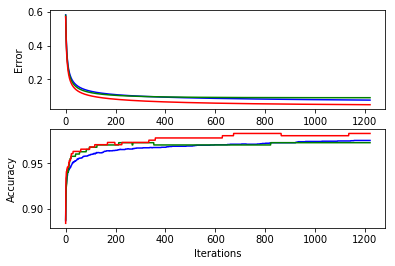

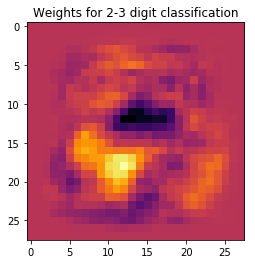

In [40]:
# Best learning rate = 0.1

weightsCurr = gradientDescent(x, t, 0.1, 0.0, 10000, True)

weightsImage = np.resize(np.array(weightsCurr[1:]),(28,28))
plt.imshow(weightsImage,interpolation='none', cmap='inferno')
plt.title("Weights for 2-3 digit classification")
plt.show()

Iteration of min weights =  9999
Stopping iteration =  1
Final train classification accuracy =  0.978932178932179
Final validation classification accuracy =  0.9740932642487047
Final test classification accuracy =  0.974025974025974


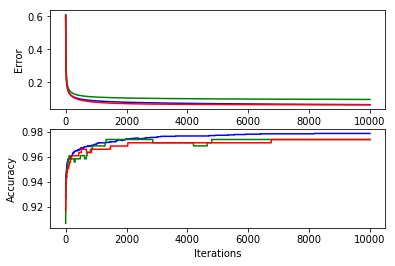

In [41]:
# 2 vs 8

images_train_8 = []
images_test_8 = []
labels_train_8 = []
labels_test_8 = []

for i in range(len(labels_train_all)):
    if (labels_train_all[i] == 2):
        images_train_8.append(images_train_all[i])
        labels_train_8.append(1)
    if (labels_train_all[i] == 8):
        images_train_8.append(images_train_all[i])
        labels_train_8.append(0)
        
for i in range(len(labels_test_all)):
    if (labels_test_all[i] == 2):
        images_test_8.append(images_test_all[i])
        labels_test_8.append(1)
    if (labels_test_all[i] == 8):
        images_test_8.append(images_test_all[i])
        labels_test_8.append(0)

images_train_8 = np.array(images_train_8)
labels_train_8 = np.array(labels_train_8)
images_test_8 = np.array(images_test_8)
labels_test_8 = np.array(labels_test_8)

images_train_8 = images_train_8*(1/255)
images_test_8 = images_test_8*(1/255)

images_train_8, images_validation_8, labels_train_8, labels_validation_8 = train_test_split(images_train_8, labels_train_8, test_size=0.10)

x = [images_train_8, images_validation_8, images_test_8]
t = [labels_train_8, labels_validation_8, labels_test_8]
weights_8 = gradientDescent(x, t, 0.1, 0.0, 10000, True)

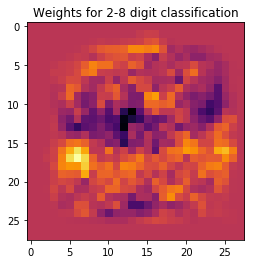

In [42]:
# Plot the weight for 2-8
weightsImage_8 = np.resize(np.array(weights_8[1:]),(28,28))
plt.imshow(weightsImage_8,interpolation='none', cmap='inferno')
plt.title("Weights for 2-8 digit classification")
plt.show()

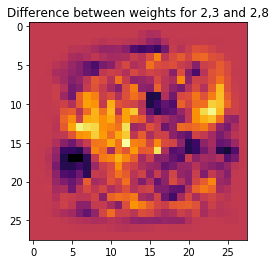

In [44]:
# Plot difference between weights
diff38 = weightsImage-weightsImage_8
plt.imshow(diff38,interpolation='none', cmap='inferno')
plt.title("Difference between weights for 2,3 and 2,8")
plt.show()

Regularization =  0.1 Learning Rate =  0.1
Iteration of min weights =  74
Stopping iteration =  77
Final train classification accuracy =  0.955049944506
Final validation classification accuracy =  0.955112219451
Final test classification accuracy =  0.962962962963


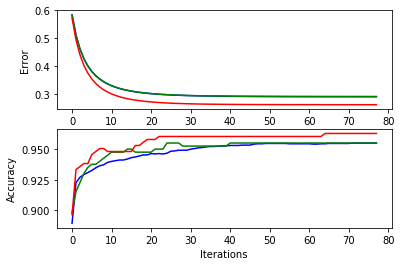

Regularization =  0.01 Learning Rate =  0.1
Iteration of min weights =  358
Stopping iteration =  361
Final train classification accuracy =  0.966981132075
Final validation classification accuracy =  0.967581047382
Final test classification accuracy =  0.975308641975


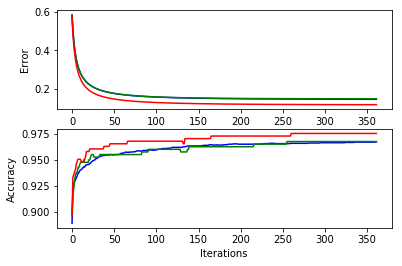

Regularization =  0.001 Learning Rate =  0.1
Iteration of min weights =  999
Stopping iteration =  1
Final train classification accuracy =  0.972807991121
Final validation classification accuracy =  0.965087281796
Final test classification accuracy =  0.982716049383


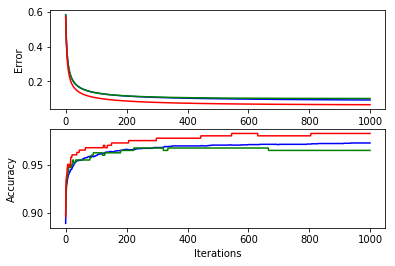

Regularization =  10 Learning Rate =  0.1
Iteration of min weights =  0
Stopping iteration =  51
Final train classification accuracy =  0.889289678135
Final validation classification accuracy =  0.897755610973
Final test classification accuracy =  0.896296296296


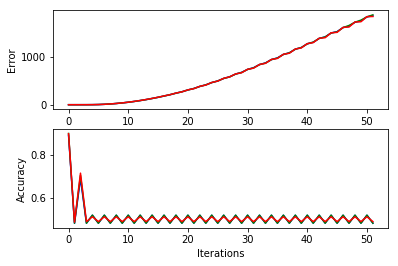

Regularization =  1 Learning Rate =  0.1
Iteration of min weights =  18
Stopping iteration =  51
Final train classification accuracy =  0.934517203108
Final validation classification accuracy =  0.937655860349
Final test classification accuracy =  0.945679012346


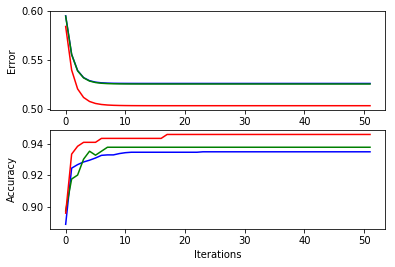

In [20]:
# With regularization L1

x = [images_train, images_validation, images_test]
t = [labels_train, labels_validation, labels_test]

for reg in [0.1, 0.01, 0.001, 10, 1]:
    for learning_rate in [0.1]:
        print("Regularization = ", reg, "Learning Rate = ", learning_rate)
        gradientDescent(x, t, learning_rate, reg, 10000, True)

In [ ]:
# With regularization L2

for reg in [0.1, 0.01, 0.001]:
    for learning_rate in [0.001, 0.0001, 0.0003]:
        print("Regularization = ", reg, "Learning Rate = ", learning_rate)
        gradientDescent(x, t, learning_rate, reg, 10000, True)